# Deploy a Model on Truefoundry
In this module we will deploy an already trained model on Truefoundry

# 🛠 Setup
To follow along with the notebook, you will have to do the following:
* Install **mlfoundry** and required ML Libraries
* Setup logging
* Select the Workspace in which you want to deploy your application.
* Install the required packages

In [ ]:
!pip install -U -q "mlfoundry==0.10.5" "tensorflow==2.15.0" "matplotlib==3.8.2" "servicefoundry==0.9.28"

In [ ]:
import logging
[logging.root.removeHandler(h) for h in logging.root.handlers]
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(name)s] %(levelname)-8s %(message)s')

### Login into truefoundry
In order to login run the cell below. Host can be found from the Truefoundry UI as shown below like https://app.truefoundry.com

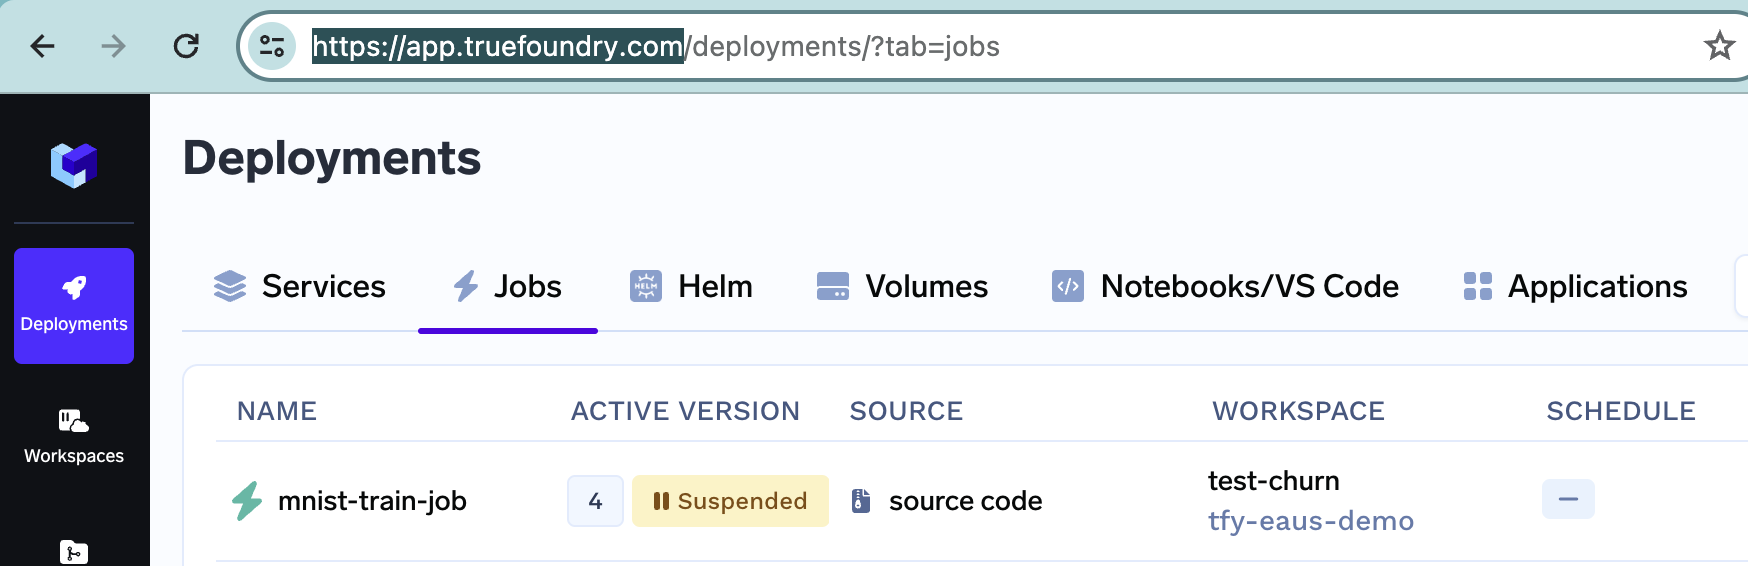

In [ ]:
!mlfoundry login --host <Host name of Truefoundry UI. e.g. https://company.truefoundry.cloud>

### Workspace FQN
Once you run the cell below you will get a prompt to enter your workspace. <br>
* Step 1: Click on the link given in the prompt.
* Step 2: Identify the Workspace you want to deploy the application in.
* Step 3: Copy the Workspace FQN <br>
![Copying Workspace FQN](https://files.readme.io/730fee2-Screenshot_2023-02-28_at_2.08.34_PM.png)
* Step 4: Paste the  Workspace FQN in the prompt and press enter.

In [ ]:
WORKSPACE_FQN = input("Enter the FQN of the workspace to use: ")

## Loading the model saved in Truefoundry

In [ ]:
MODEL_VERSION_FQN = input("Enter the Model Version FQN (Can be found in run details of training job)")

In [ ]:
import mlfoundry as mlf
import os

client = mlf.get_client()
model_version = client.get_model_version_by_fqn(MODEL_VERSION_FQN)
download_path = model_version.download('.', overwrite=True)

model_file = os.path.join(download_path.model_dir, "mnist_model.h5")

In [ ]:
from deploy_model.predict import load_model, predict_fn

model = load_model(model_file)

## Try out a sample inference

In [ ]:
import tensorflow as tf
test_img = tf.keras.utils.load_img('deploy_model/sample_images/0.jpg', target_size=(28, 28))
img_arr = tf.keras.preprocessing.image.img_to_array(test_img)

In [ ]:
test_img

In [ ]:
predict_fn(model,img_arr)

## Deploying the model

### Inference Scripts

In [51]:
!pygmentize deploy_model/predict.py

import tensorflow as tf

def load_model(model_path):
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    return model

def predict_fn(model, img_arr):
  # Preprocess the image before passing it to the model
  img_arr = tf.expand_dims(img_arr, 0)
  img_arr = img_arr[:, :, :, 0]  # Keep only the first channel (grayscale)

  # Make predictions
  predictions = model.predict(img_arr)
  predicted_label = tf.argmax(predictions[0]).numpy()

  return str(predicted_label)


In [52]:
!pygmentize deploy_model/gradio_demo.py

from predict import predict_fn, load_model
import os
import gradio as gr

model_path = os.path.join(
    os.environ.get("MODEL_DOWNLOAD_PATH", "."), "mnist_model.h5"
)
model = load_model(model_path)

def get_inference(img_arr):
    return predict_fn(model, img_arr)

interface = gr.Interface(
    fn=get_inference,
    inputs="image",
    outputs="label",
    examples=[["sample_images/0.jpg"], ["sample_images/1.jpg"]]
)

interface.launch(server_name="0.0.0.0", server_port=8000)


### Deploy on Truefoundry as Service

In [53]:
!pygmentize deploy_model/deploy.py

import argparse
import logging
from servicefoundry import (
    Build,
    PythonBuild,
    Service,
    Resources,
    Port,
    ArtifactsDownload,
    TruefoundryArtifactSource,
)

logging.basicConfig(level=logging.INFO)

parser = argparse.ArgumentParser()
parser.add_argument("--workspace_fqn", type=str, required=True)
parser.add_argument("--model_version_fqn", type=str, required=True)
parser.add_argument("--host", type=str, required=True)
parser.add_argument("--path", type=str, required=False)
args = parser.parse_args()

service = Service(
    name="mnist-classification-svc",
    image=Build(
        build_spec=PythonBuild(
            command="python gradio_demo.py",
            requirements_path="requirements.txt",
        )
    ),
    ports=[Port(port=8000, host=args.host, path=args.path)],
    resources=Resources(
        memory_limit=500,
        memory_request=500,
        ephemeral_storage_limit=600,
        ephemeral_storage_request=600,
        cpu_limit=0.3,
        cpu_re

In [55]:
SERVICE_HOST = input("Enter the Service Host (Can be found from cluster details in Truefoundry UI)")
SERVICE_PATH = input("Enter the Service Path where you want your service to be deployed")

In [ ]:
!cd deploy_model/ && python deploy.py --workspace_fqn $WORKSPACE_FQN --model_version_fqn $MODEL_VERSION_FQN --host $SERVICE_HOST --path $SERVICE_PATH